In [2]:
import numpy as np

#fetch_mldata -> openml로 변경되었지만 똑같은 데이터 형식 유지하기 (솜장 블로그 참고)
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1] 
    mnist.data[:60000] = mnist.data[reorder_train] 
    mnist.target[:60000] = mnist.target[reorder_train] 
    mnist.data[60000:] = mnist.data[reorder_test + 60000] 
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try: 
    from sklearn.datasets import fetch_openml 
    mnist = fetch_openml('mnist_784', version=1, cache=True) 
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings 
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset 
except ImportError: 
    from sklearn.datasets import fetch_mldata 
    mnist = fetch_mldata('MNIST original')

### 1. 데이터 전처리

이 이미지 데이터의 레이블은 1


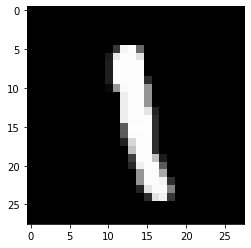

In [14]:
#이미지 데이터와 레이블 데이터 분리, 정규화

X = mnist.data / 255 #0~255의 값을 [0,1]구간의 값으로 정규화
y = mnist.target

import matplotlib.pyplot as plt

#예시로 하나의 데이터를 시각화
plt.imshow(X[7000].reshape(28,28), cmap = 'gray')
print("이 이미지 데이터의 레이블은 {:.0f}".format(y[7000]))

### 2. DataLoader 생성
- train data, test data로 분할
- numpy배열을 tensor객체로 변환
- dataset 객체 생성
- dataset 객체를 DataLoader 객체로 변환

In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [16]:
#6:1비율로  트레인 데이터, 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/7, random_state = 0)

#데이터를 파이토치 텐서로 변환
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train) #정수형 데이터는 longTensor 객체로
y_test = torch.LongTensor(y_test)

#데이터와 정답 레이블을 묶어 Dataset으로 만듦
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

#미니배치 크기를 지정해 DataLoader객체로 변환
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True) #신경망의 결합가중치를 한번에 수정할 때 사용되는 데이터 건수 == 배치 사이즈
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False) #테스트 데이터는 굳이 섞을 필요 없음

### 3. 신경망 구성

In [17]:
#케라스 스타일
from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1,100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2',nn.Linear(100,100))
model.add_module('relu2',nn.ReLU())
model.add_module('fc3', nn.Linear(100,10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


### 4. 오차함수 및 최적화 기법 설정

In [18]:
from torch import optim

#오차 함수
loss_fn = nn.CrossEntropyLoss()

#최적화 함수 for가중치 학습
optimizer = optim.Adam(model.parameters(),lr=0.01)

### 5. 학습 및 추론 설정

In [19]:
def train(epoch):
    model.train() #신경망을 학습 모드로 전환
    
    #데이터 로더에서 미니배치를 하나씩 꺼내 학습 수행
    for data, targets in loader_train:
        optimizer.zero_grad() #경사를 0으로 초기화
        outputs = model(data) #데이터 입력하고 출력을 계산
        loss = loss_fn(outputs, targets) 
        loss.backward() #오차 역전파
        optimizer.step() #역전파 값으로 가중치 수정
    
    print("epoch{}: 완료\n".format(epoch))

In [22]:
def test():
    model.eval() #신경망을 테스트 모드로 전환
    correct = 0
    
    #데이터로더에서 미니 배치 하나씩 꺼내 테스트
    with torch.no_grad(): #미분 없이
        for data, targets in loader_test:
            
            outputs = model(data) #데이터 입력 후 출력 계산
            
            _, predicted = torch.max(outputs.data, 1) #확률이 가장 높은 레이블은 무엇
            correct += predicted.eq(targets.data.view_as(predicted)).sum() #정답과 일치하면 정답 카운트 ++
    
    #accuracy
    data_num = len(loader_test.dataset) #총 데이터 수
    print("\n 테스트 데이터 예측 정확도: {}/{} ({:.0f}%)\n".format(correct, data_num, 100.*correct/data_num))

### 6.학습 및 추론 수행

In [23]:
#학습 전, 테스트 데이터 정확도 측정
test()


 테스트 데이터 예측 정확도: 908/10000 (9%)



In [24]:
for epoch in range(3):
    train(epoch)
    
test()

epoch0: 완료

epoch1: 완료

epoch2: 완료


 테스트 데이터 예측 정확도: 9615/10000 (96%)

